<a href="https://colab.research.google.com/github/nk696701/Thermal_Energy_Prediction/blob/main/Application_of_ML_to_TES_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import os
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score,roc_curve ,auc
import tensorflow as tf
import matplotlib.pyplot as plt

**CNN Architecture**

In [ ]:

def create_cnn(width=154, height=154, depth=3, filters=(16, 32, 64)):
    inputShape = (height, width, depth)
    chanDim = -1

    input = tf.keras.Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        if i == 0:
            x = input
        # CONV => RELU => BN => POOL
        x = tf.keras.layers.Conv2D(f, 3, padding="same")(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.BatchNormalization(axis=chanDim)(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.BatchNormalization(axis=chanDim)(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.BatchNormalization(axis=chanDim)(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.BatchNormalization(axis=chanDim)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(11)(x)
    x = tf.keras.layers.Activation("sigmoid")(x)

    # construct the CNN
    model = tf.keras.Model(input, x)

    # return the CNN
    return model


# Preprocessing


**Code to use when train and test images are in seperate folders**

In [ ]:

def process_data(data_path):
    data = {}
    X = np.empty((0, 154, 154, 3), float)
    Y = np.empty((0), int)

    for classes in os.listdir(data_path):
        img_path = os.path.join(data_path, classes)
        cls = int(classes)
        if data.get(cls) is None:
            data[cls] = []

        for images in os.listdir(img_path):
            fmt = images.split('.')
            if fmt[-1] == "jpg":
                image_path = os.path.join(img_path, images)
                img = Image.open(image_path)
                width, height = img.size
                top_crop = 66
                bottom_crop = 20
                left_crop = 43
                right_crop = 43
                box = (left_crop, top_crop, width-right_crop, height-bottom_crop)
                cropped_img = img.crop(box)
                data[cls].append(np.array(cropped_img))
                img.close()

        n_data = len(data[cls])
        Y = np.append(Y, [cls] * n_data, axis=0)
        X = np.append(X, data[cls], axis=0)

    return X, Y





In [ ]:
# Process train data
train_path = '/content/drive/MyDrive/Colab Notebooks/Thermal Energy Prediction/Ushara training data/'
X_train, Y_train = process_data(train_path)

# Process test data
test_path = '/content/drive/MyDrive/Colab Notebooks/Thermal Energy Prediction/June 12,14 data/'
X_test, Y_test = process_data(test_path)

# Perform one-hot encoding for Y_train
num_classes = len(np.unique(Y_train))
Y_train_encoded = np.zeros((num_classes, len(Y_train)))
for i in range(len(Y_train)):
    Y_train_encoded[Y_train[i] // 10, i] = 1

**Code to use when train and test images are in one single folder**

In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/Thermal Energy Prediction/test_data/'
data = {}
for classes in os.listdir(base_path):
    img_path = base_path+classes+'/'
    cls = int(classes)
    if  data.get(cls) is None:
        data[cls] = []

    for images in os.listdir(img_path):
        fmt = images.split('.')

        if fmt[-1] == "jpg":
            id = fmt[0]
            image_path = img_path + images
            img = Image.open(image_path)
            width, height = img.size
            top_crop = 66
            bottom_crop = 20
            left_crop = 43
            right_crop = 43
            box = (left_crop, top_crop, width-right_crop, height - bottom_crop)
            cropped_img = img.crop(box)
            data[cls].append(np.array(cropped_img))
            img.close()

n_train = 4
Y_train = np.empty((0), int)
Y_test = np.empty((0), int)
X_train = np.empty((0,154,154,3), float)
X_test = np.empty((0,154,154,3), float)

for label in data:
    #if label != 90:
        n = len(data[label])
        Y_train = np.append(Y_train, [label]*n_train, axis=0)
        X_train = np.append(X_train, data[label][0:n_train], axis=0)
        n -= n_train
        Y_test = np.append(Y_test, [label]*n, axis=0)
        X_test = np.append(X_test, data[label][n_train:], axis=0)
""" else:
        dtr = np.array(data[label][0])
        dtr = dtr[np.newaxis,:]
        dte = np.array(data[label][1])
        dte = dte[np.newaxis,:]
        Y_train = np.append(Y_train, [label], axis=0)
        X_train = np.append(X_train, dtr, axis=0)
        Y_test = np.append(Y_test, [label], axis=0)
X_test = np.append(X_test, dte, axis=0)"""

"""X_train = np.append(X_train, X_test, axis=0)
Y_train = np.append(Y_train, Y_test, axis=0)
X_test = X_train
Y_test = Y_train"""

Y = np.zeros((10, len(Y_train)))
for i in range(0,len(Y_train)):
    Y[Y_train[i]//10,i] = 1

# Training the model

In [ ]:
model = create_cnn(154, 154, 3)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=X_train, y=Y_train_encoded.T, epochs=50, batch_size=50)

# Testing


In [ ]:
preds = model.predict(X_test)
y_pred = np.zeros(len(preds))

for i in range(0,len(preds)):
    y_pred[i] = 10 * np.argmax(preds[i,:])

print("Confusion Matrix :")
print(confusion_matrix(Y_test, y_pred))
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(Y_test, y_pred)))


10/10 [==============================] - 4s 332ms/step
Confusion Matrix :
[[15  1  0  0  0  0  0  0  0  0  0]
 [ 5 13  6  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0]
 [ 2  0  4 25  0  0  0  0  0  0  0]
 [ 1  0  0 11 22  1  0  0  0  0  0]
 [ 1  0  0  8  0 25  0  0  0  0  0]
 [ 4  0  0  1  1  4 25  2  0  0  0]
 [ 0  0  0  0  1  2  5 38  0  0  1]
 [ 0  0  0  0  0  0  3  5 25  0  4]
 [ 0  0  0  0  0  0  0  3  4  8  3]
 [ 0  0  0  0  0  0  0  4  5  0  5]]

Accuracy: 0.71



In [ ]:
# Perform one-hot encoding for Y_test
Y_test_encoded = np.zeros((num_classes, len(Y_test)))
for i in range(len(Y_test)):
    Y_test_encoded[Y_test[i] // 10, i] = 1

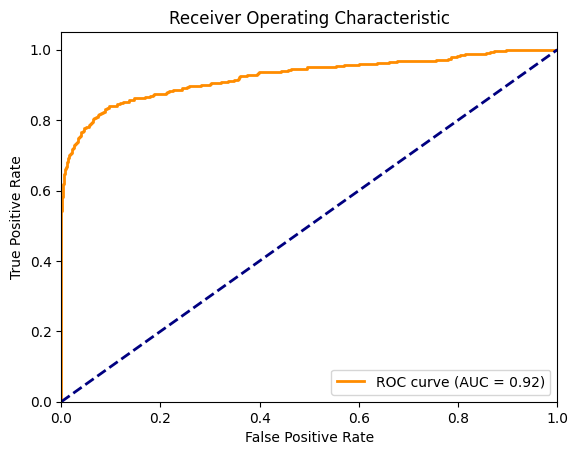

In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test_encoded.T.flatten(), preds.flatten())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()